In [2]:
import numpy as np
import glob
import scipy.signal as scs
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, VoigtModel, LinearModel, ConstantModel
import CESfunctionsJUNOx23 as cf

In [3]:
calfactors=(7.092125e+02, -1.173492e-01,
            -1.805713e-05,6.237604e-09)


In [7]:
spec=np.arange(1,1025,1)

In [8]:
# Prepare reference and convolution

In [10]:
ref1=np.loadtxt("NO3.txt")
#ref2=np.load("CHOCHO.npy")
wavelengths=cf.andor_calibrator(len(spec),*calfactors)
ref1int = np.interp(wavelengths[:,0],ref1[:,0],ref1[:,1])
#ref2int = np.interp(wavelengths[:,0],ref2[:,0],ref2[:,1])

Text(0.5, 1.0, 'Reference and Interpolation')

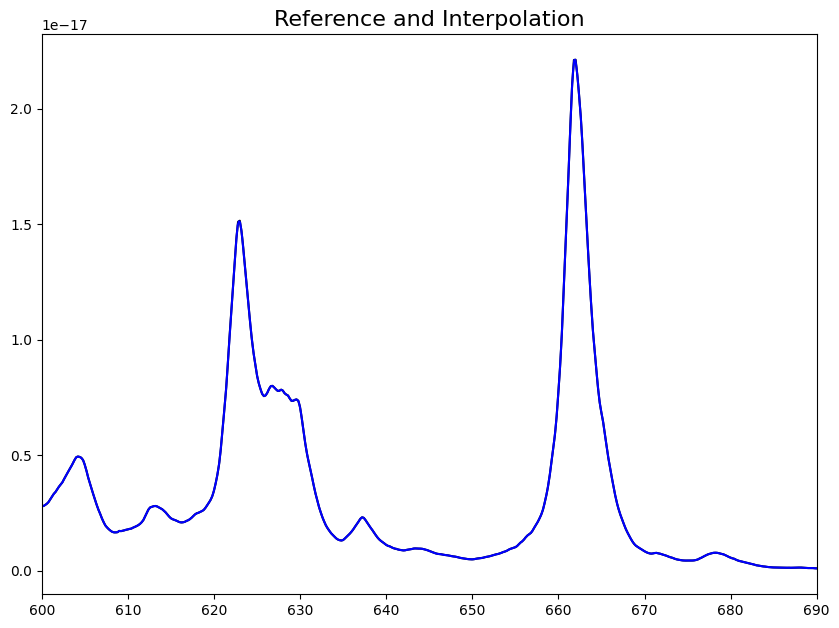

In [11]:
f = plt.figure(figsize=(10,16))
ax1 = f.add_subplot(211)
#ax2 = f.add_subplot(212)

ax1.plot(ref1[:,0],ref1[:,1],'-k')
ax1.plot(wavelengths[:,0],ref1int,'-b')
ax1.set_xlim(600,690)
ax1.set_title("Reference and Interpolation",size=16)

#ax2.plot(ref2[:,0],ref2[:,1],'-k')
#ax2.plot(wavelengths[:,0],ref2int,'-b')
#ax2.set_xlim(430,470)
#ax2.set_title("Reference and Interpolation",size=16)

In [15]:
lamp=np.loadtxt('NeLampSlitOFF.csv',delimiter=',')
lamp_cal = np.concatenate((wavelengths[:,:],lamp[:,1].reshape(len(lamp[:,1]),1)),axis=1)

Text(0.5, 1.0, 'Calibration lines')

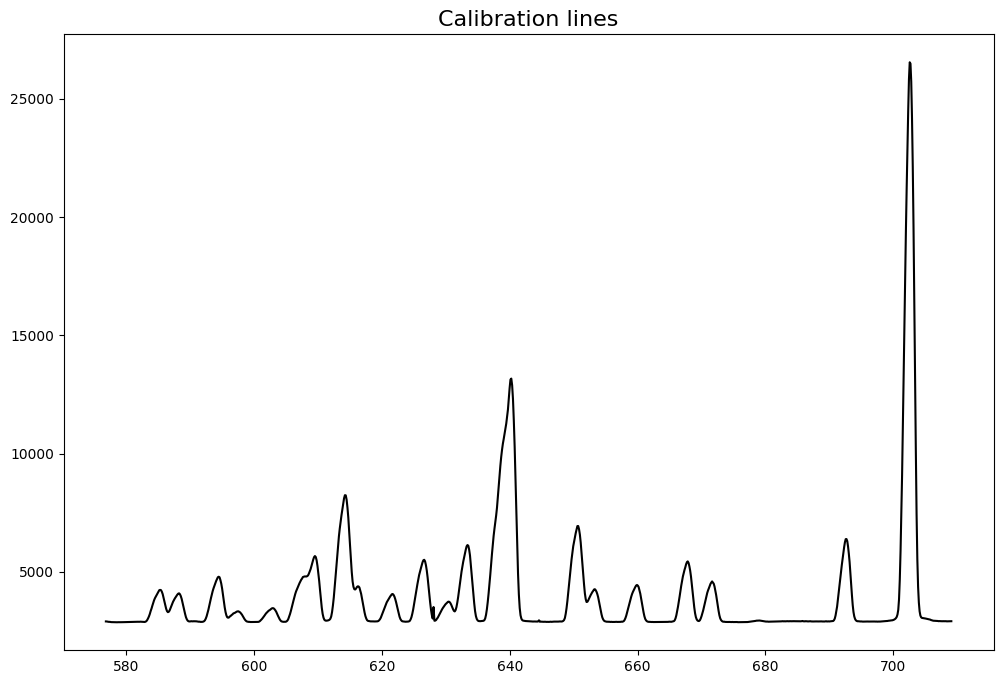

In [16]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(111)

ax1.plot(lamp_cal[:,0],lamp_cal[:,1],'-k')
ax1.set_title("Calibration lines",size=16)

In [23]:
### Find the line closer to your range, get its maximun, center it with and get your lineshape vector
section=np.nonzero((lamp_cal[:,0]<=664) & (lamp_cal[:,0]>=654))
center=np.nonzero(lamp_cal[:,1]==np.amax(lamp_cal[section[0][0]:section[0][-1],1]))
lineshape = np.copy(lamp_cal[center[0][0]-20:center[0][0]+21,:])
lineshape[:,1]=lineshape[:,1]-np.amin(lineshape[:,1])
lineshape[:,1]=(lineshape[:,1])/(np.amax(lineshape[:,1]))
np.amin(lineshape[:,1])

0.0

In [24]:
### Let's fit the lineshape to some Gaussian and Voigt profiles using lmfit
model = GaussianModel()
model2 = VoigtModel()

# create parameters with initial values
params = model.make_params(amplitude=1, center=660,sigma=.5)
params2 = model2.make_params(amplitude=1, center=660,sigma=.5)

# maybe place bounds on some parameters
#params['center'].min = 2
#params['center'].max = 12
#params['amplitude'].max = 0. 

# do the fit, print out report with results 
result = model.fit(lineshape[:,1], params, x=lineshape[:,0])
result2 = model2.fit(lineshape[:,1], params2, x=lineshape[:,0])
print(result.fit_report())
print(result2.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 41
    # variables        = 3
    chi-square         = 0.08765861
    reduced chi-square = 0.00230681
    Akaike info crit   = -246.062976
    Bayesian info crit = -240.922260
    R-squared          = 0.98451644
[[Variables]]
    amplitude:  2.00194548 +/- 0.03516889 (1.76%) (init = 1)
    center:     659.739577 +/- 0.01587206 (0.00%) (init = 660)
    sigma:      0.78254370 +/- 0.01587864 (2.03%) (init = 0.5)
    fwhm:       1.84274954 +/- 0.03739134 (2.03%) == '2.3548200*sigma'
    height:     1.02059571 +/- 0.01792851 (1.76%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5776
[[Model]]
    Model(voigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 41
    # variables        = 3
    chi-square         = 0.23709853
 

Text(0.5, 1.0, 'Line shape and fits')

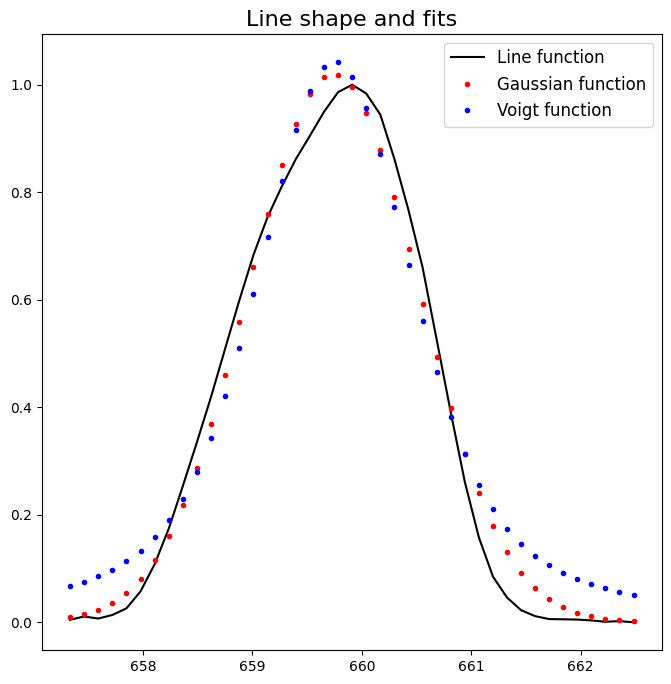

In [25]:
f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
ax1.plot(lineshape[:,0],lineshape[:,1]-np.amin(lineshape[:,1]),'-k',label="Line function")
ax1.plot(lineshape[:,0],result.best_fit,'.r',label="Gaussian function")
ax1.plot(lineshape[:,0],result2.best_fit,'.b',label="Voigt function")
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("Line shape and fits",size=16)

In [26]:
### Perform the convolution with the original lineshape and the fits
conv11 = np.convolve(ref1int,lineshape[:,1],mode='same')
#conv12 = np.convolve(ref2int,lineshape[:,1],mode='same')
conv21 = np.convolve(ref1int,result.best_fit,mode="same")
#conv22 = np.convolve(ref2int,result.best_fit,mode="same")
conv31 = np.convolve(ref1int,result2.best_fit,mode="same")
#conv32 = np.convolve(ref2int,result2.best_fit,mode="same")

8.476535703932598e-16 8.482108144825865e-16 8.482108144825865e-16 8.482108144825865e-16


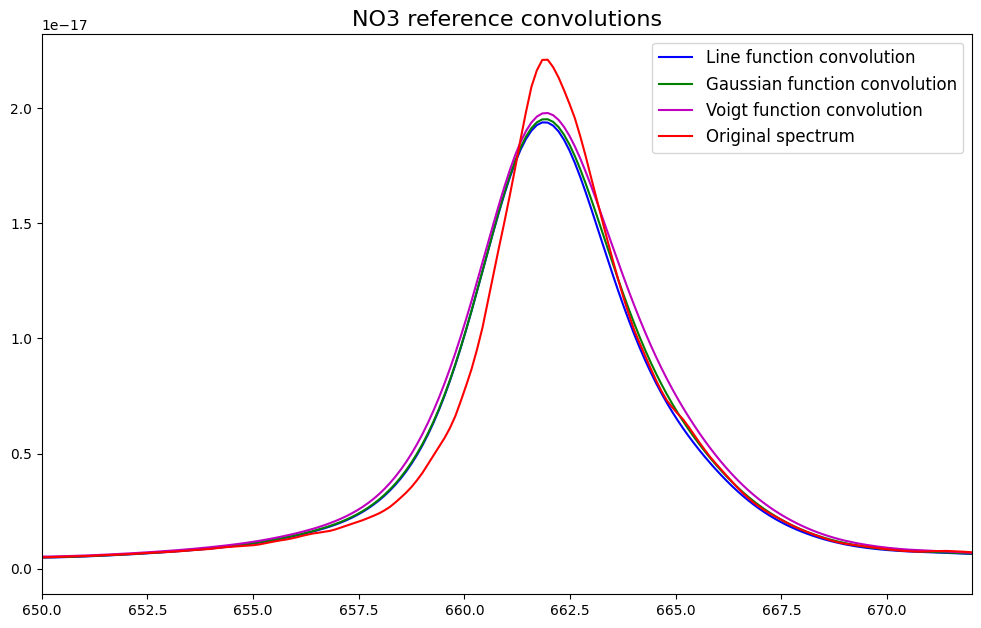

In [70]:
f = plt.figure(figsize=(12,16))
ax1 = f.add_subplot(211)
#ax2 = f.add_subplot(212)
a=15
b=0.5e-19
ax1.plot(wavelengths[:,0],conv11/a-b,'-b',label="Line function convolution")
ax1.plot(wavelengths[:,0],conv21/a-b,'-g',label="Gaussian function convolution")
ax1.plot(wavelengths[:,0],conv31/a-b,'-m',label="Voigt function convolution")
#ax1.plot(wavelengths[:,0],conv11/a-b,'-k',label="Line function convolution (adjusted)")
ax1.plot(wavelengths[:,0],ref1int,'-r',label="Original spectrum")
ax1.set_xlim(650,672)
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("NO3 reference convolutions",size=16)
aref = np.trapz(ref1int[275:500])
a11 = np.trapz(conv11[275:500]/a-b)
a12 = np.trapz(conv11[275:500]/a-b)
a13 = np.trapz(conv11[275:500]/a-b)
print(aref,a11,a12,a13)
#ax2.plot(wavelengths[:,0],conv12,'-b',label="Line function convolution")
#ax2.plot(wavelengths[:,0],conv22,'-g',label="Gaussian function convolution")
#ax2.plot(wavelengths[:,0],conv32,'-m',label="Voigt function convolution")
#ax2.plot(wavelengths[:,0],conv12/6,'-k',label="Line function convolution (adjusted)")
#ax2.plot(wavelengths[:,0],ref2int,'-r',label="Original spectrum")
#ax2.set_xlim(400,500)
#ax2.legend(fontsize=12, loc='upper right')
#ax1.set_title("Reference 2 convolutions",size=16)

In [67]:
ref1conv=conv11/a-b
#ref2conv=conv12/6

np.save("NO3_IASC",np.concatenate((wavelengths,ref1conv.reshape(len(ref1conv),1)),axis=1))
#np.save("CHOCHO_AvSC",np.concatenate((wavelengths,ref2conv.reshape(len(ref2conv),1)),axis=1))

In [ ]:
### making the extinction spectrum

In [42]:
wls = cf.andor_calibrator(1024,*calfactors)
sigmas_N2 = []
for wl in wls:
    wn = (1/wl)*1e7
    a = 5677.465
    b = 318.81874e12
    c = 14.4e9
    N = 2.546899e19
    Fk = 1.034+3.17e-12*np.power(wn,2)
    pre_n = a + (b/(c-np.power(wn,2))) 
    n = (pre_n/1e8)+1
    sigma_1st = 24 * np.power(np.pi,3) * np.power(wn,4)/np.power(N,2)
    sigma_2nd = (np.power(n,2)-1)/(np.power(n,2)+2)
    sigma = sigma_1st * np.power(sigma_2nd,2)*Fk
    sigmas_N2.append(sigma[0])

sigmas_O2 = []
for wl in wls:
    wn = (1/wl)*1e7
    a = 20564.8
    b = 2.480899e13
    c = 4.09e9
    N = 2.68678e19
    Fk = 1.096+1.385e-11*np.power(wn,2)+1.448e-20*np.power(wn,4)
    pre_n = a + (b/(c-np.power(wn,2))) 
    n = (pre_n/1e8)+1
    sigma_1st = 24 * np.power(np.pi,3) * np.power(wn,4)/np.power(N,2)
    sigma_2nd = (np.power(n,2)-1)/(np.power(n,2)+2)
    sigma = sigma_1st * np.power(sigma_2nd,2)*Fk
    sigmas_O2.append(sigma[0])
    
sigmas_Ar = []
for wl in wls:
    wn = (1/wl)*1e7
    a = 6432.135
    b = 286.06021e12
    c = 14.4e9
    N = 2.546899e19
    Fk = 1
    pre_n = a + (b/(c-np.power(wn,2))) 
    n = (pre_n/1e8)+1
    sigma_1st = 24 * np.power(np.pi,3) * np.power(wn,4)/np.power(N,2)
    sigma_2nd = (np.power(n,2)-1)/(np.power(n,2)+2)
    sigmaAr = sigma_1st * np.power(sigma_2nd,2)*Fk
    sigmas_Ar.append(sigma[0])
sigma_Air = np.array(sigmas_N2)*.78084+np.array(sigmas_O2)*.20947+np.array(sigmas_Ar)*.00934

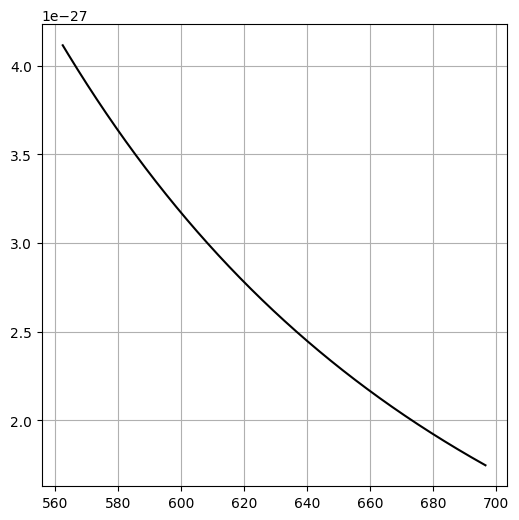

In [43]:
f= plt.figure(figsize=(6,6))
ax1 = f.add_subplot(111)

#ax1.plot(wls[minwave:maxwave],sigma_Air[minwave:maxwave],'-k')

ax1.plot(wls,sigma_Air,'-k')
ax1.grid()

In [45]:
no3reference= np.load('NO3_IASC.npy')
minwave,maxwave = cf.segment_indices(no3reference,650,
                672)
np.save('sigma_ray_short',sigma_Air[minwave:maxwave])
np.save('sigma_ray',sigma_Air)